In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder , StandardScaler
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import statsmodels.api as sm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, plot_roc_curve

In [3]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [4]:
g = test['PassengerId']

In [5]:
g.head()

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.shape

(891, 12)

In [8]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
def changer(cabin):
    if pd.isnull(cabin) :
            category = 'Unkonwn'
    else :
            category = cabin[0]
    return(category)

In [12]:
def change_age(moyen_age, data, title_list):
    for title in title_list:
        p = data['Title'] == title 
        data.loc[p, 'Age'] = data.loc[p, 'Age'].fillna(moyen_age[title]) 

In [13]:
Fare = train['Fare']
Age  = train['Age']

In [14]:
def pre(dataframe):
    dataframe.drop(['Ticket','PassengerId'], 1, inplace=True)
    dataframe['Cabin'] = pd.DataFrame([changer(cabin) for cabin in dataframe['Cabin'].values])
    dataframe['FamSize'] = dataframe['SibSp']+dataframe['Parch']+1
    dataframe.drop(['SibSp','Parch'], 1, inplace=True)
    dataframe['Title'] = dataframe.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataframe.drop(['Name'], 1, inplace=True)
    y =['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don', 'Dona']
    for i in y :
      dataframe['Title'] = dataframe['Title'].replace(i, 'Others')
      dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
      dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')
      dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Embarked']=dataframe['Embarked'].fillna('S')
    M = dataframe.groupby('Title')['Age'].mean()
    title = ['Master','Miss','Mr','Mrs','Others']
    change_age(M, dataframe, title)
    df =pd.get_dummies(dataframe[['Embarked','Title']], drop_first=True)
    for i in df.columns : 
         dataframe[i] = df[i]
    dataframe.drop(['Embarked','Title'], 1, inplace=True)
    dataframe['log(Fare)+1'] = (dataframe['Fare']+1).transform(np.log)
    dataframe['log(Age)+1'] = (dataframe['Age']+1).transform(np.log)
    dataframe.drop(['Age','Fare'], 1, inplace=True)
    return(dataframe)

In [15]:
data= pre(train)

In [16]:
le1 = LabelEncoder()
le2 = LabelEncoder()
data['Cabin'] = le1.fit_transform(data['Cabin'])
data['Sex'] = le2.fit_transform(data['Sex'])

In [17]:
data.head()

,Survived,Pclass,Sex,Cabin,FamSize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others,log(Fare)+1,log(Age)+1
0,0,3,1,8,2,0,1,0,1,0,0,2.110213,3.135494
1,1,1,0,2,2,0,0,0,0,1,0,4.280593,3.663562
2,1,3,0,8,1,0,1,1,0,0,0,2.188856,3.295837
3,1,1,0,2,2,0,1,0,0,1,0,3.990834,3.583519
4,0,3,1,8,1,0,1,0,1,0,0,2.202765,3.583519


Text(0.5, 0, 'Log Fare')

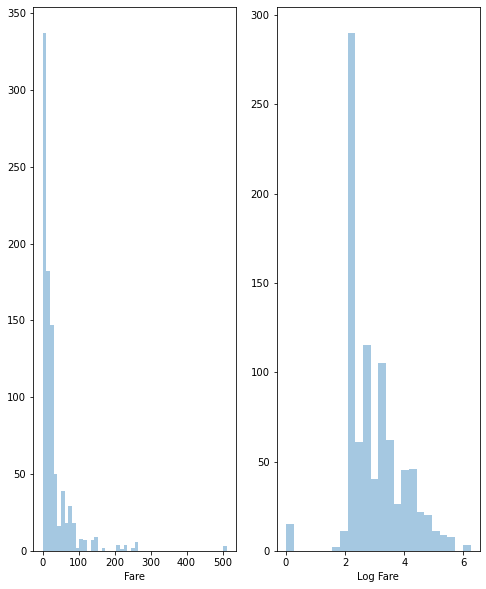

In [18]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)

plt.subplot(1, 2, 1)
sns.distplot(Fare, kde=False)

plt.subplot(1, 2, 2)
sns.distplot(np.log(Fare + 1), kde=False)
plt.xlabel('Log Fare')

Text(0.5, 0, 'Log Age')

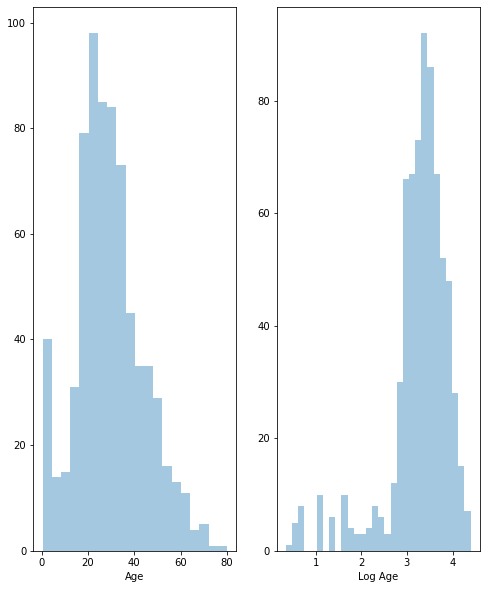

In [19]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)

plt.subplot(1, 2, 1)
sns.distplot(Age, kde=False)

plt.subplot(1, 2, 2)
sns.distplot(np.log(Age + 1), kde=False)
plt.xlabel('Log Age')

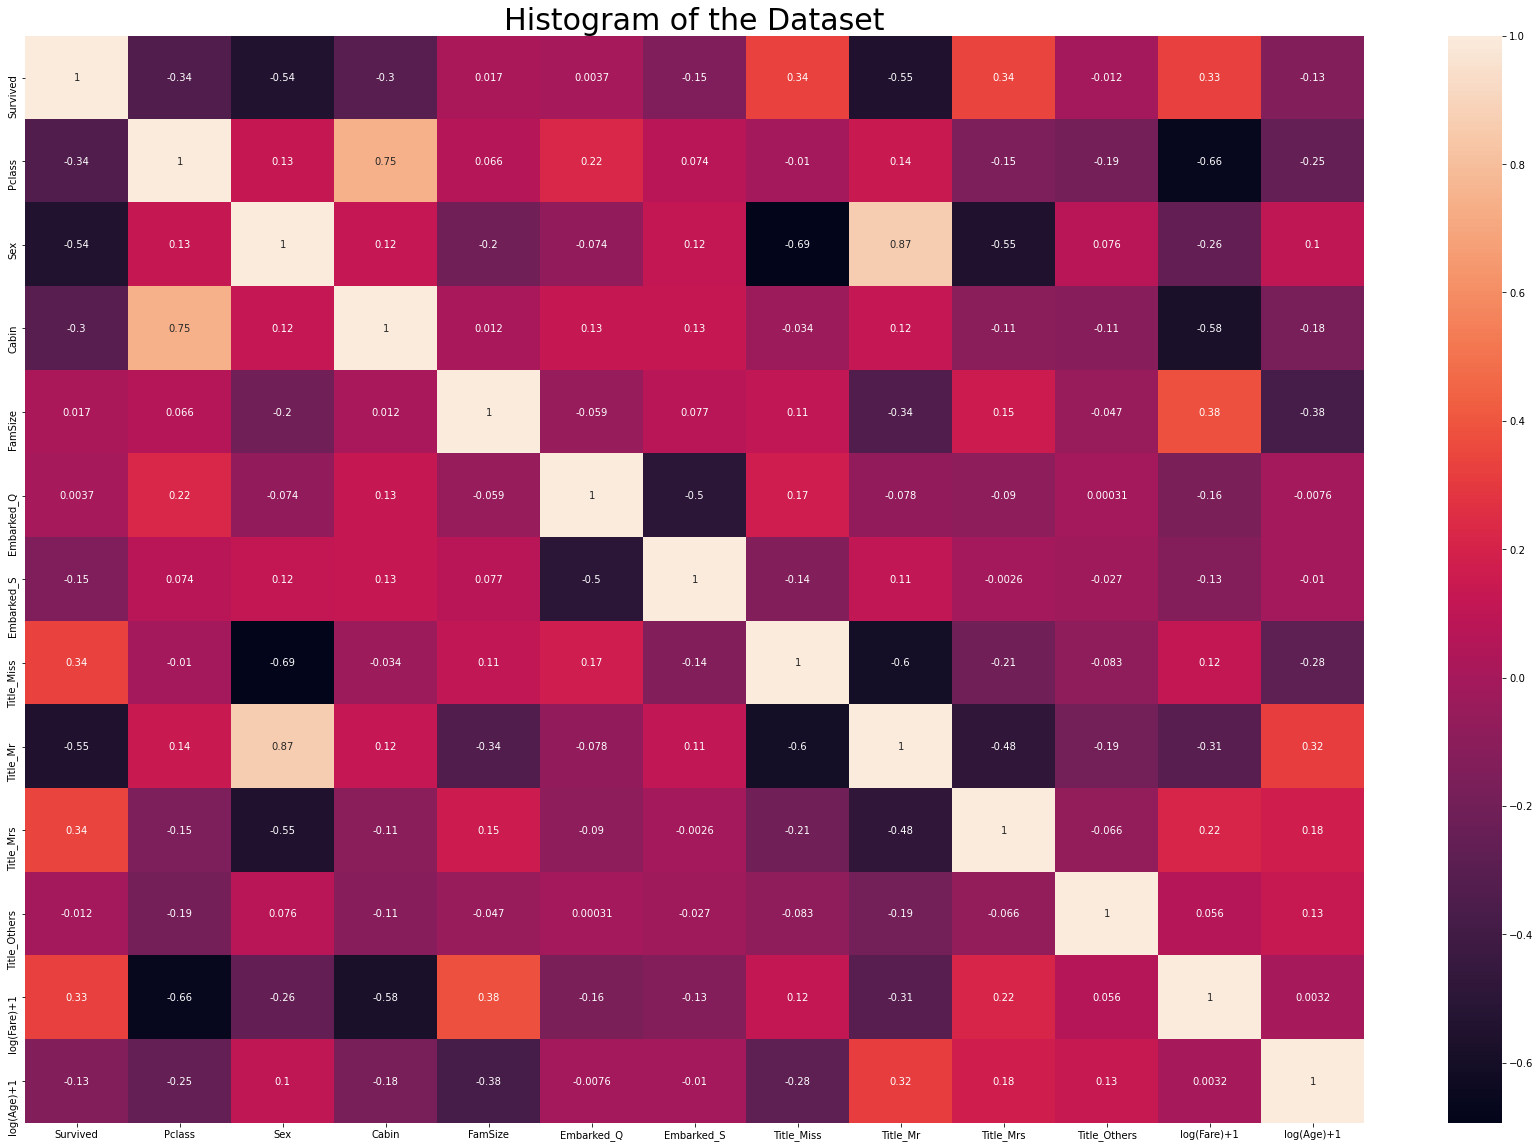

In [20]:
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(data.corr(), annot = True)

plt.title('Histogram of the Dataset', fontsize = 30)
plt.show()

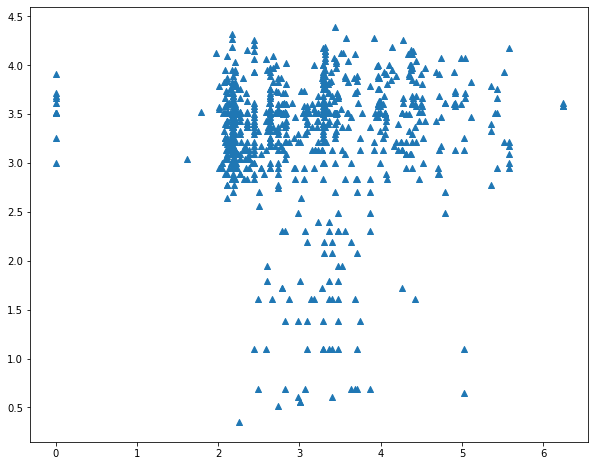

In [21]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.scatter(data['log(Fare)+1'] ,data['log(Age)+1'] ,marker="^")
plt.show()

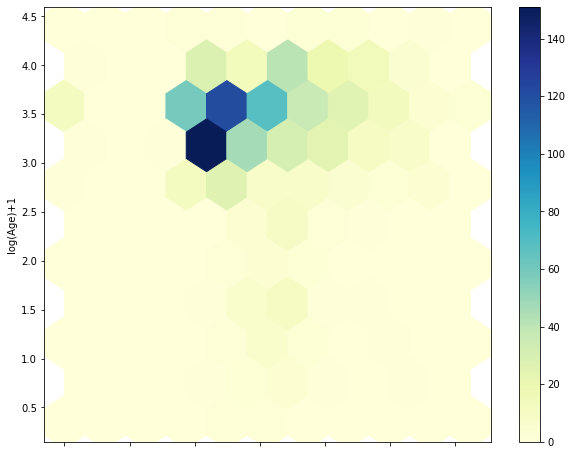

In [22]:
data.plot.hexbin(x='log(Fare)+1', y='log(Age)+1', gridsize=10,cmap="YlGnBu")
plt.show()

In [23]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Cabin', 'FamSize', 'Embarked_Q',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Others',
       'log(Fare)+1', 'log(Age)+1'],
      dtype='object')

In [24]:
data.describe()

,Survived,Pclass,Sex,Cabin,FamSize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others,log(Fare)+1,log(Age)+1
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,6.716049,1.904602,0.086420,0.725028,0.207632,0.580247,0.141414,0.025814,2.962246,3.287180
std,0.486592,0.836071,0.477990,2.460739,1.613459,0.281141,0.446751,0.405840,0.493796,0.348644,0.158668,0.969048,0.629565
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350657
25%,0.000000,2.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.187218,3.128760
50%,0.000000,3.000000,1.000000,8.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.737881,3.433987
75%,1.000000,3.000000,1.000000,8.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.465736,3.605199
max,1.000000,3.000000,1.000000,8.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.240917,4.394449


In [25]:
data.head()

,Survived,Pclass,Sex,Cabin,FamSize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others,log(Fare)+1,log(Age)+1
0,0,3,1,8,2,0,1,0,1,0,0,2.110213,3.135494
1,1,1,0,2,2,0,0,0,0,1,0,4.280593,3.663562
2,1,3,0,8,1,0,1,1,0,0,0,2.188856,3.295837
3,1,1,0,2,2,0,1,0,0,1,0,3.990834,3.583519
4,0,3,1,8,1,0,1,0,1,0,0,2.202765,3.583519


In [26]:
features = data
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
FamSize,2.722848
Survived,0.477717
log(Fare)+1,0.394263
Sex,-0.617878
Pclass,-0.629486
Cabin,-1.543536
log(Age)+1,-2.114003


In [27]:
high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
FamSize,0.967476
Survived,0.477717
log(Fare)+1,0.394263
Sex,-0.617878
Pclass,-0.629486
Cabin,-1.543536
log(Age)+1,-2.114003


In [28]:
X = data.drop(['Survived'], 1)
y = data['Survived']

In [29]:
ols = sm.OLS(endog = y, exog = X)
fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']

In [30]:
outliers = list(test2[test2<1e-3]) 
outliers

[]

In [31]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [32]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.94:
        overfit.append(i)

In [33]:
overfit = list(overfit)
overfit

[]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [35]:
red_tsne = TSNE(n_components=2,random_state=42).fit_transform(X_train)
red_pca = PCA(n_components=2, random_state = 42).fit_transform(X_train)
red_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 42).fit_transform(X_train)

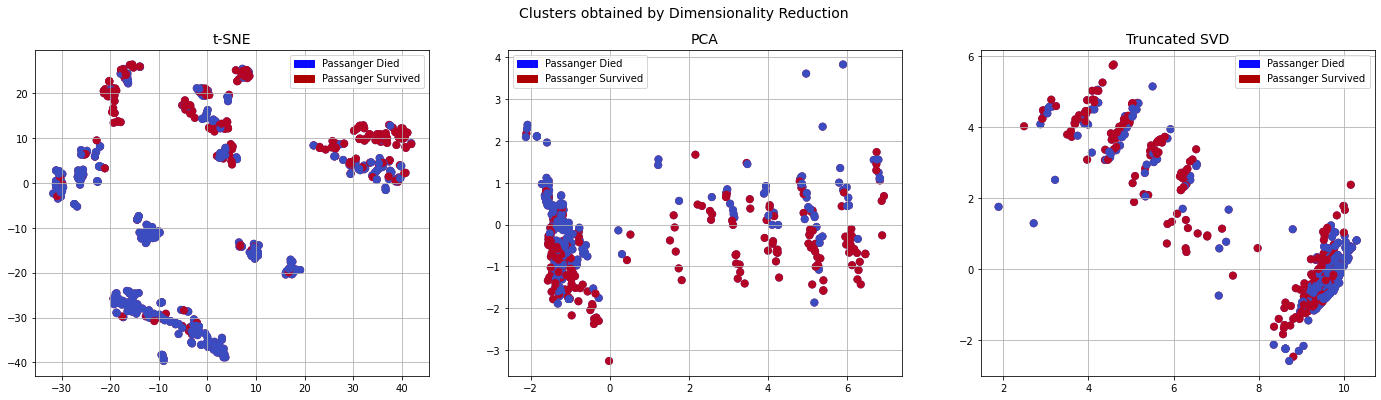

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters obtained by Dimensionality Reduction', fontsize=14)
blue_patch = mpatches.Patch(color='#0A0AFF', label='Passanger Died')
red_patch = mpatches.Patch(color='#AF0000', label='Passanger Survived')
ax1.scatter(red_tsne[:,0], red_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='Passanger Died', linewidths=2)
ax1.scatter(red_tsne[:,0], red_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='Passanger Survived', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])
ax2.scatter(red_pca[:,0], red_pca[:,1], c=(y_train == 0), cmap='coolwarm', label='Passanger Died', linewidths=2)
ax2.scatter(red_pca[:,0], red_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Passanger Survived', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])
ax3.scatter(red_svd[:,0], red_svd[:,1],c=(y_train == 0), cmap='coolwarm', label='Passanger Died', linewidths=2)
ax3.scatter(red_svd[:,0], red_svd[:,1],c=(y_train == 1), cmap='coolwarm', label='Passanger Survived', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])
plt.show()

In [37]:
train_accuracies = {'Logistic Regression':0, 'Support Vector Classifier':0, 'K-Neighbors Classifier':0, 'Random Forest Classifier':0,
                   'Decision Tree Classifier': 0 , 'XGBoost Classifier':0 , 'lightgbm Classifier' : 0}
test_accuracies = {'Logistic Regression':0, 'Support Vector Classifier':0, 'K-Neighbors Classifier':0, 'Random Forest Classifier':0,
                   'Decision Tree Classifier': 0 , 'XGBoost Classifier':0 , 'lightgbm Classifier' : 0}

In [38]:
lgr = LogisticRegression()
params = {"C" : np.logspace(-4, -1, 4),
          "penalty" : ["l2"]}
lgr_grid = GridSearchCV(lgr, params, scoring='accuracy', cv=5)
_ = lgr_grid.fit(X_train, y_train)

In [39]:
train_preds = lgr_grid.predict(X_train)
test_preds = lgr_grid.predict(X_test)
print("Logistic Regression results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['Logistic Regression'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['Logistic Regression'] = accuracy_score(test_preds, y_test)*100

Logistic Regression results :
   -   Accuracy on the train set : 81.60%
   -   Accuracy on the test set : 79.89%


In [40]:
svc = SVC()
param_grid = {'C': np.logspace(-2, 2, 3),
              'kernel': ['linear']}
svc_grid = GridSearchCV(svc, param_grid, scoring='accuracy', cv=5)
_ = svc_grid.fit(X_train, y_train)

In [41]:
train_preds = svc_grid.predict(X_train)
test_preds = svc_grid.predict(X_test)
print("Support Vector Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['Support Vector Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['Support Vector Classifier'] = accuracy_score(test_preds, y_test)*100

Support Vector Classifier results :
   -   Accuracy on the train set : 79.92%
   -   Accuracy on the test set : 79.89%


In [42]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,31),
          'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)
_ = knn_grid.fit(X_train,y_train)

In [43]:
train_preds = knn_grid.predict(X_train)
test_preds = knn_grid.predict(X_test)
print("K-Neighbors Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['K-Neighbors Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['K-Neighbors Classifier'] = accuracy_score(test_preds, y_test)*100

K-Neighbors Classifier results :
   -   Accuracy on the train set : 84.83%
   -   Accuracy on the test set : 81.56%


In [44]:
rf = RandomForestClassifier(random_state=42)
params = {'n_estimators': [2**i for i in range(3,9)],
          'max_depth': np.arange(1,21),
          'min_samples_split': np.linspace(0.1, 0.6, 6),
          'min_samples_leaf': np.linspace(0.1, 0.3, 5),
          'max_leaf_nodes': 10*np.arange(1,19),
          'max_features': np.arange(1,11)/10}
rf_grid = RandomizedSearchCV(rf, params, scoring='accuracy', cv=5, random_state=42, n_iter=100)
_ = rf_grid.fit(X_train,y_train)

In [45]:
train_preds = rf_grid.predict(X_train)
test_preds = rf_grid.predict(X_test)
print("Random Forest Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['Random Forest Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['Random Forest Classifier'] = accuracy_score(test_preds, y_test)*100

Random Forest Classifier results :
   -   Accuracy on the train set : 79.63%
   -   Accuracy on the test set : 77.09%


In [46]:
dt = DecisionTreeClassifier(random_state=42)
params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
dt_grid = RandomizedSearchCV(dt, params, scoring='accuracy', cv=5, random_state=42)
_ = dt_grid.fit(X_train,y_train)

In [47]:
train_preds = dt_grid.predict(X_train)
test_preds = dt_grid.predict(X_test)
print("Decision Tree Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['Decision Tree Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['Decision Tree Classifier'] = accuracy_score(test_preds, y_test)*100

Decision Tree Classifier results :
   -   Accuracy on the train set : 89.75%
   -   Accuracy on the test set : 81.01%


In [48]:
xgb = XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
xg_grid = RandomizedSearchCV(xgb, parameters, scoring='accuracy', cv=5, random_state=42)
_ = xg_grid.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[14:32:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:32:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:32:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


In [49]:
train_preds = xg_grid.predict(X_train)
test_preds = xg_grid.predict(X_test)
print("XGBoost Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['XGBoost Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['XGBoost Classifier'] = accuracy_score(test_preds, y_test)*100

XGBoost Classifier results :
   -   Accuracy on the train set : 82.58%
   -   Accuracy on the test set : 75.98%


In [50]:
model = lgb.LGBMClassifier()
param_grid = {'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]}
lg_grid = RandomizedSearchCV(model, param_grid, scoring='accuracy', cv=5, random_state=42)
_ = lg_grid.fit(X_train,y_train)

In [51]:
train_preds = lg_grid.predict(X_train)
test_preds = lg_grid.predict(X_test)
print("lightgbm Classifier results :")
print("   -   Accuracy on the train set : {:.2f}%".format(accuracy_score(train_preds, y_train)*100))
train_accuracies['lightgbm Classifier'] = accuracy_score(train_preds, y_train)*100
print("   -   Accuracy on the test set : {:.2f}%".format(accuracy_score(test_preds, y_test)*100))
test_accuracies['lightgbm Classifier'] = accuracy_score(test_preds, y_test)*100

lightgbm Classifier results :
   -   Accuracy on the train set : 86.52%
   -   Accuracy on the test set : 80.45%


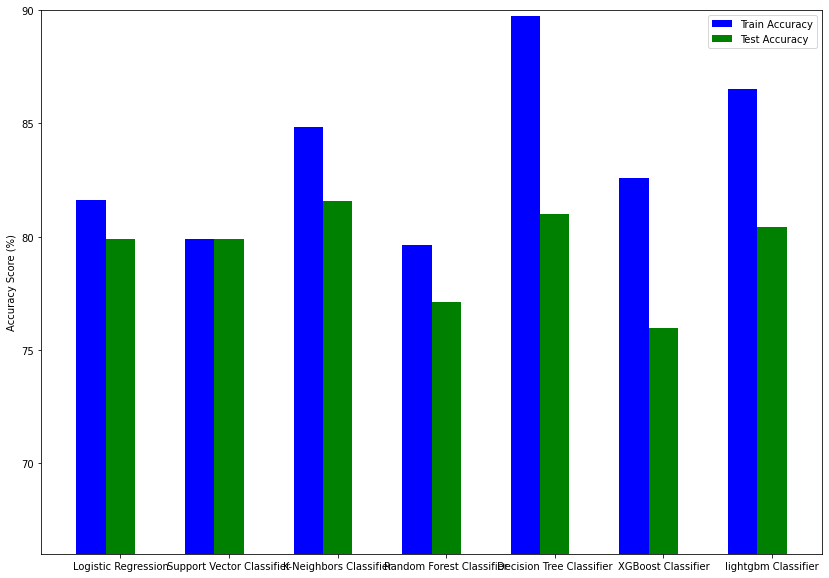

In [52]:
ind = np.arange(7)
width = 0.27

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, list(train_accuracies.values()), width, color='b')
rects2 = ax.bar(ind+width, list(test_accuracies.values()), width, color='g')

ax.set_ylabel('Accuracy Score (%)')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Logistic Regression', 'Support Vector Classifier', 'K-Neighbors Classifier', 'Random Forest Classifier', 'Decision Tree Classifier'
                    , 'XGBoost Classifier', 'lightgbm Classifier') )
ax.legend((rects1[0], rects2[0]), ('Train Accuracy', 'Test Accuracy'))

plt.ylim((66,90))
plt.show()

In [53]:
classifiers = [lgr_grid, svc_grid, knn_grid, rf_grid, dt_grid, xg_grid, lg_grid]
result_table = pd.DataFrame(columns=['fpr','tpr','auc'])
for clf in classifiers :
  if clf in [rf_grid, knn_grid, dt_grid,xg_grid , lg_grid] :
    y_score = clf.predict_proba(X_test)[::,1]
  else :
    y_score = clf.decision_function(X_test)
  fpr, tpr, _ = roc_curve(y_test,  y_score)
  auc = roc_auc_score(y_test, y_score)
  result_table = result_table.append({'fpr':fpr, 
                                      'tpr':tpr, 
                                      'auc':auc}, ignore_index=True)
result_table.index = ['Logistic Regression', 'Support Vector Classifier', 'K-Neighbors Classifier', 'Random Forest Classifier', 'Decision Tree Classifier'
                    , 'XGBoost Classifier', 'lightgbm Classifier']

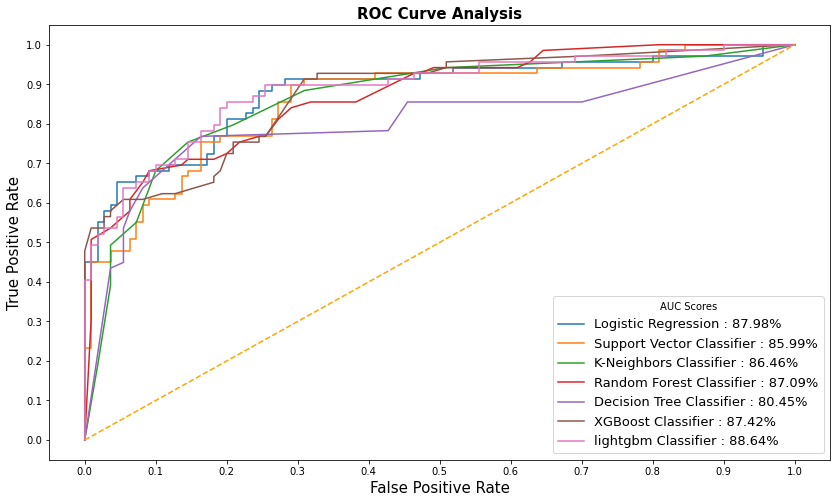

In [54]:
fig = plt.figure(figsize=(14,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{} : {:.2f}%".format(i, result_table.loc[i]['auc']*100))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right', title='AUC Scores')

plt.show()

In [55]:
test['Fare'].fillna(test['Fare'].mean(), inplace = True)

In [56]:
test=pre(test)

In [57]:
test['Sex'] = le2.transform(test['Sex'])
test['Cabin'] = le1.transform(test['Cabin'])

In [58]:
test.head()

,Pclass,Sex,Cabin,FamSize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others,log(Fare)+1,log(Age)+1
0,3,1,8,1,1,0,0,1,0,0,2.178064,3.569533
1,3,0,8,2,0,1,0,0,1,0,2.079442,3.871201
2,2,1,8,1,1,0,0,1,0,0,2.369075,4.143135
3,3,1,8,1,0,1,0,1,0,0,2.268252,3.332205
4,3,0,8,3,0,1,0,0,1,0,2.586824,3.135494


In [59]:
features = test
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
FamSize,3.157161
log(Fare)+1,0.855152
Pclass,-0.532252
Sex,-0.566947
Cabin,-1.589891
log(Age)+1,-2.395039


In [60]:
high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
FamSize,0.965689
log(Fare)+1,0.445863
Pclass,-0.532252
Sex,-0.566947
Cabin,-1.589891
log(Age)+1,-2.395039


In [61]:
test.head()

,Pclass,Sex,Cabin,FamSize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others,log(Fare)+1,log(Age)+1
0,3,1,8,0.541888,1,0,0,1,0,0,1.572935,3.569533
1,3,0,8,0.751237,0,1,0,0,1,0,1.516695,3.871201
2,2,1,8,0.541888,1,0,0,1,0,0,1.679467,4.143135
3,3,1,8,0.541888,0,1,0,1,0,0,1.623617,3.332205
4,3,0,8,0.865873,0,1,0,0,1,0,1.797345,3.135494


In [62]:
test.isnull().sum()

Pclass          0
Sex             0
Cabin           0
FamSize         0
Embarked_Q      0
Embarked_S      0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Others    0
log(Fare)+1     0
log(Age)+1      0
dtype: int64

In [63]:
pred = lgr_grid.predict(test)

In [64]:
output = pd.DataFrame({'PassengerId': g ,'Survived': pred})

filename = 'My Results.csv'

output.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: My Results.csv


In [65]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
